In [40]:
import os
import re
import json
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import namedtuple

palette = sns.color_palette("Set2", 10)
sns.set_context("notebook", font_scale=2.0)

First define the paths where the data is located

In [2]:
train_annotations_path = '/Users/zal/CMU/Spring2017/16824/FinalProject/Data/charades/Charades_vu17_train.csv'
test_annotations_path = '/Users/zal/CMU/Spring2017/16824/FinalProject/Data/charades/Charades_vu17_validation.csv'
classes_path = '/Users/zal/CMU/Spring2017/16824/FinalProject/Data/charades/Charades_v1_classes.txt'
video_len_path = '/Users/zal/CMU/Spring2017/16824/FinalProject/Data/charades/VideoLength.csv'
verb_map_path = '/Users/zal/CMU/Spring2017/16824/FinalProject/Data/charades/Charades_v1_mapping.txt'

Load the action names

In [3]:
action_names = {}
for line in open(classes_path).readlines():
    if line:
        action_id = line[:4]
        action_name = line[5:].strip()
        action_names[action_id] = action_name
print len(action_names.keys())
print action_names['c000']

157
Holding some clothes


Then read the csv file with the annotations

In [4]:
fields_header = 'id,subject,scene,quality,relevance,verified,script,objects,descriptions,actions,length'
fields_list = fields_header.split(',')
fields = {}
for i,field in enumerate(fields_list):
    fields[field]=i

Load the data from the csv

In [5]:
csv_rdr = csv.reader(open(train_annotations_path))
train_annotations = list(csv_rdr)[1:]
print len(train_annotations)
print train_annotations[0][fields['actions']]

7985
c092 11.90 21.20;c147 0.00 12.60


Extract all the actions from the annotations and build the sample tuples

*(id, action, start, end, length)*

In [6]:
def load_actions_from_csv(csv_path, fields):
    csv_rdr = csv.reader(open(csv_path))
    train_annotations = list(csv_rdr)[1:]
    actions_list = []
    for anno in train_annotations:
        video_id = anno[fields['id']]
        if anno[fields['actions']]:
            for action in anno[fields['actions']].split(';'):
                action_id, start, end = action.split(' ')
                actions_list.append((video_id, action_id, float(start), float(end), float(end)-float(start)))

    return actions_list

train_list = load_actions_from_csv(train_annotations_path, fields)
test_list = load_actions_from_csv(test_annotations_path, fields)

print 'The total number of annotations are: {}'.format(len(train_list) + len(test_list))
print 'The train dataset has a total of {} annotated actions.'.format(len(train_list))
print 'The test dataset has a total of {} annotated actions.'.format(len(test_list))

The total number of annotations are: 66500
The train dataset has a total of 49809 annotated actions.
The test dataset has a total of 16691 annotated actions.


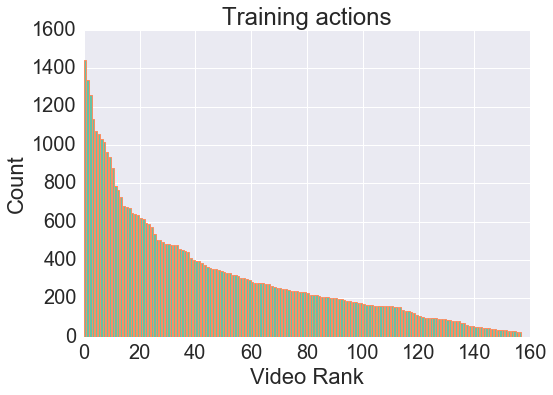

Top 10 actions
(1444)	Walking through a doorway
(1341)	Someone is standing up from somewhere
(1260)	Sitting in a chair
(1134)	Drinking from a cup/glass/bottle
(1075)	Holding some food
(1055)	Holding a phone/camera
(1029)	Someone is smiling
(1014)	Holding a cup/glass/bottle of something
(964)	Someone is going from standing to sitting
(936)	Someone is eating something


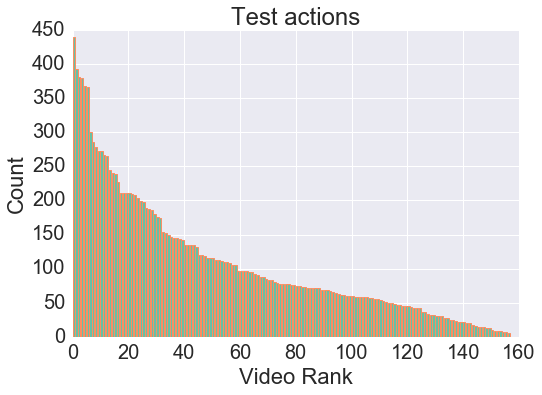

Top 10 actions
(439)	Walking through a doorway
(393)	Someone is smiling
(381)	Someone is standing up from somewhere
(380)	Holding a cup/glass/bottle of something
(368)	Sitting in a chair
(367)	Holding some food
(300)	Drinking from a cup/glass/bottle
(285)	Putting something on a table
(279)	Someone is going from standing to sitting
(273)	Opening a door


In [43]:
def plot_hist_action_list(actions_list, title='Actions',K=10):
    # Count the occurrence of each action
    train_actions_list = zip(*actions_list)[1]
    actions_count = {}
    for action in train_actions_list:
        if action in actions_count:
            actions_count[action] += 1
        else:
            actions_count[action] = 1
    # Prepare count for bar plot: sort and turn to number
    actions_count = sorted(actions_count.items(), key=lambda x:x[1], reverse=True)
    actions, counts = zip(*actions_count)
    counts = [int(c) for c in counts]
    # Plot the sorted 
    plt.clf()
    plt.bar(range(len(counts)), counts, color=palette[0], edgecolor=palette[1], lw=1)
    plt.title(title)
    plt.xlabel('Video Rank')
    plt.ylabel('Count')
    plt.show()
    print 'Top {} actions'.format(K)
    for action,count in zip(actions[:K], counts[:K]):
        print '({})\t{}'.format(count, action_names[action])

plot_hist_action_list(train_list, 'Training actions')
plot_hist_action_list(test_list, 'Testing actions')

Store annotations into file and the frames version:

## Video lengths

In [8]:
video_length_map = {}
video_length_list = []
len_csv_rdr = csv.reader(open(video_len_path))

for video_id, video_len in len_csv_rdr:
    video_length_map[video_id] = int(video_len)
    video_length_list.append(int(video_len))
    
print 'Total videos: {}'.format(len(video_length_map))
print 'Video ZC8L5 has {} frames'.format(video_length_map['ZC8L5']) # must be 703 [frames]

print 'Min len:  {}'.format(min(video_length_list))
print 'Max len:  {}'.format(max(video_length_list))
print 'Mean len: {}'.format(np.mean(video_length_list))
print 'Median len: {}'.format(np.median(video_length_list))
print 'SD len:  {}'.format(np.std(video_length_list))
print 'Var len:  {}'.format(np.var(video_length_list))

Total videos: 9848
Video ZC8L5 has 744 frames
Min len:  57
Max len:  4665
Mean len: 712.917140536
Median len: 734.0
SD len:  220.414755721
Var len:  48582.6645397


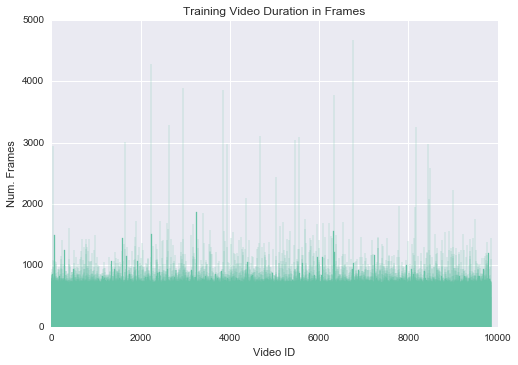

In [9]:
# plot the video duration in frames
plt.clf()
plt.bar(range(len(video_length_list)), video_length_list, color=palette[0], edgecolor=palette[0])
plt.xlabel('Video ID')
plt.ylabel('Num. Frames')
plt.title('Training Video Duration in Frames')
plt.show()

## Clip lengths

In [10]:
clip_lengths = zip(*train_list)[4]
clip_lengths = [x for x in clip_lengths if x > 0]
clip_lengths = map(lambda x: int(x*24), clip_lengths)
print 'Min len:  {}'.format(min(clip_lengths))
print 'Max len:  {}'.format(max(clip_lengths))
print 'Mean len: {}'.format(np.mean(clip_lengths))
print 'Median len: {}'.format(np.median(clip_lengths))
print 'SD len:  {}'.format(np.std(clip_lengths))
print 'Var len:  {}'.format(np.var(clip_lengths))

Min len:  45
Max len:  3633
Mean len: 309.741516405
Median len: 216.0
SD len:  225.279358746
Var len:  50750.7894771


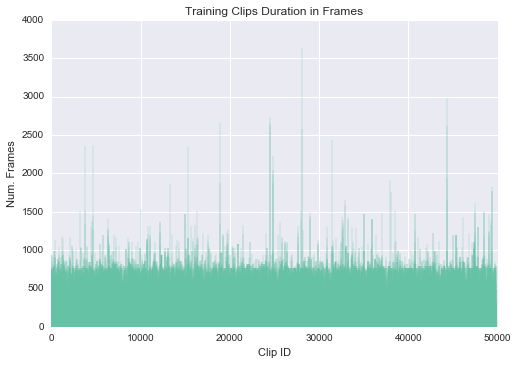

In [11]:
plt.clf()
plt.bar(range(len(clip_lengths)), clip_lengths, color=palette[0], edgecolor=palette[0])
plt.xlabel('Clip ID')
plt.ylabel('Num. Frames')
plt.title('Training Clips Duration in Frames')
plt.show()

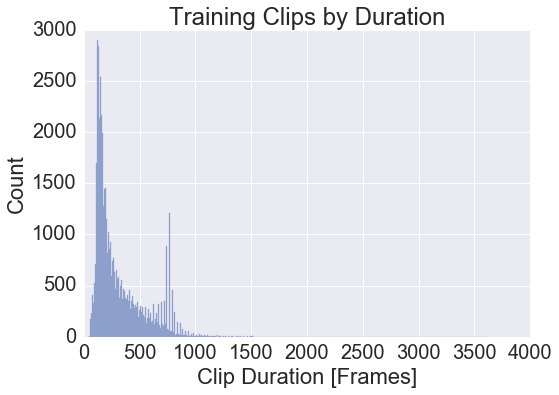

In [27]:
plt.clf()
plt.hist(clip_lengths, color=palette[2], edgecolor=palette[2], bins=400) #~100 per bin
plt.xlabel('Clip Duration [Frames]')
plt.ylabel('Count')
plt.title('Training Clips by Duration')
plt.show()

## Build action map

In [29]:
action_verb_map = {}
verb_csv_rdr = csv.reader(open(verb_map_path), delimiter=' ')
for action_id, _, verb_id in verb_csv_rdr:
    action_verb_map[action_id] = verb_id

In [30]:
clips_save_path = '../Data/charades/Action_Clips.csv'
train_clips_save_path = '../src/data/Train_Clips_Frames.csv'
test_clips_save_path = '../src/data/Test_Clips_Frames.csv'

def save_clip_list(save_path, clip_list, fps=24):
    clips_save_file = open(save_path, 'w')
    for clip in clip_list:    
        video_id = clip[0]
        class_id = action_verb_map[clip[1]]
        start_frame = int(clip[2]*fps)
        end_frame = int(clip[3]*fps)
        if video_id in video_length_map:
            if video_length_map[video_id] < end_frame:
                end_frame = video_length_map[video_id]  
        else:
            print '{} not found'.format(video_id)
        
        line_output = '%s,%d,%d,%d,%s\n'%(video_id, start_frame, end_frame , end_frame - start_frame, class_id)
        clips_save_file.write(line_output)
        
save_clip_list(train_clips_save_path, train_list)
save_clip_list(test_clips_save_path, test_list)

## Verb List

In [54]:
# Load the verb labels in a list
verb_class_path = '/Users/zal/CMU/Spring2017/16824/FinalProject/Data/charades/Charades_v1_verbclasses.txt' 
verb_csv_rdr = csv.reader(open(verb_class_path), delimiter=' ')
verb_list = []
for verb_id, verb in verb_csv_rdr:
    verb_list.append(verb)

In [31]:
train_list_labels = zip(*train_list)[1]
test_list_labels = zip(*test_list)[1]

In [47]:
#train
train_verbs_labels = map(lambda x: action_verb_map[x], train_list_labels)
train_verbs_labels = [int(re.findall(r'v(\d{3})', x)[0]) for x in train_verbs_labels]
#test
test_verbs_labels = map(lambda x: action_verb_map[x], test_list_labels)
test_verbs_labels = [int(re.findall(r'v(\d{3})', x)[0]) for x in test_verbs_labels]

In [59]:
# Calculate max and min verb labels
train_verb_label_count = [train_verbs_labels.count(x) for x in range(33)]
train_verb_max_count = max(train_verb_label_count)
train_verb_min_count = min(train_verb_label_count)
print "{}\t{}".format(train_verb_max_count, verb_list[train_verb_label_count.index(train_verb_max_count)])
print "{}\t{}".format(train_verb_min_count, verb_list[train_verb_label_count.index(train_verb_min_count)])

9871	hold
29	make


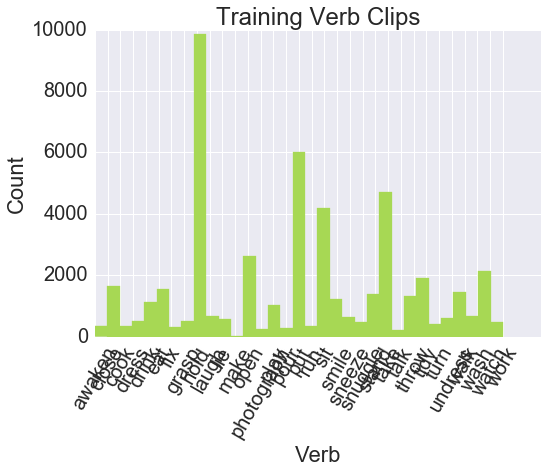

In [41]:
plt.clf()
plt.hist(train_verbs_labels, color=palette[4], edgecolor=palette[4], bins=33)
plt.xlabel('Verb')
plt.ylabel('Count')
plt.title('Training Verb Clips')
plt.xticks(range(len(verb_list)), verb_list, rotation=60)
plt.show()

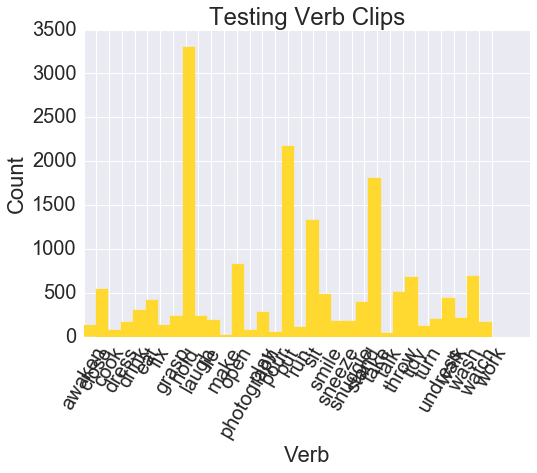

In [44]:
plt.clf()
plt.hist(test_verbs_labels, color=palette[5], edgecolor=palette[5], bins=33)
plt.xlabel('Verb')
plt.ylabel('Count')
plt.title('Testing Verb Clips')
plt.xticks(range(len(verb_list)), verb_list, rotation=60)
plt.show()